# STAT 201 Project Proposal (Group 16)
## Comparison of Break and Enter Crime in West Point Grey, Vancouver, BC pre- and post-COVID

## 1. Introduction

In late 2019, COVID-19 was first identified in Wuhan, China. It has since spread globally and was declared a pandemic by the World Health Organization in March 2020. The virus is highly contagious. It spreads through respiratory droplets when an infected person talks, coughs, or sneezes.
Vancouver had a lockdown during COVID time. In March 18, 2020, the provincial government declared a state of emergency, and implemented a number of restrictions to help slow the spread of the virus, encouraging people to stay home as much as possible.
Past research has shown that the lockdown implemented in response to the COVID-19 pandemic has had various effects, including a reduction in crime rates in general (Buil-Gil et al.; Shen et al.). We want to investigate whether or not there is a difference in break and enter crime rate comparing during COVID and pre-COVID times. More specifically, we want to look at the West Point Grey neighbourhood in Vancouver, regarding the time period from March 2020 to February 2022 for during COVID, and March 2018 to February 2020 for pre-COVID.

## 2. Preliminary Results

We begin by loading the necessary R libraries for data wrangling and statistical inference.

In [2]:
library(tidyverse)
library(broom)
library(infer)
library(zoo)

Next, we read the data from CSV files downloaded from the Vancouver Police Department (https://geodash.vpd.ca/opendata/) for the years 2018-2022 in the neighbourhood West Point Grey. This data is combined into a single data frame (wpg) which is then cleaned by selecting only the columns of interest (crime type, year, and month), categorizing crime into two-year periods representing pre-covid (March 2018 - Feb 2020) and post-covid (March 2020 - Feb 2022).

In [4]:
# Read CSV files for 2018-2022
west_point_grey_2018 <- read_csv("https://raw.githubusercontent.com/willis-cao/stat201-project-group16/main/crimedata_csv_West%20Point%20Grey_2018.csv", show_col_types = FALSE)
west_point_grey_2019 <- read_csv("https://raw.githubusercontent.com/willis-cao/stat201-project-group16/main/crimedata_csv_West%20Point%20Grey_2019.csv", show_col_types = FALSE)
west_point_grey_2020 <- read_csv("https://raw.githubusercontent.com/willis-cao/stat201-project-group16/main/crimedata_csv_West%20Point%20Grey_2020.csv", show_col_types = FALSE)
west_point_grey_2021 <- read_csv("https://raw.githubusercontent.com/willis-cao/stat201-project-group16/main/crimedata_csv_West%20Point%20Grey_2021.csv", show_col_types = FALSE)
west_point_grey_2022 <- read_csv("https://raw.githubusercontent.com/willis-cao/stat201-project-group16/main/crimedata_csv_West%20Point%20Grey_2022.csv", show_col_types = FALSE)

# Bind all CSV files into a single data frame, 
# select variables of interest (TYPE, YEAR, MONTH),
# filter and classify crimes as pre- and post-COVID
wpg <- rbind(west_point_grey_2018, 
             west_point_grey_2019,
             west_point_grey_2020,
             west_point_grey_2021,
             west_point_grey_2022) |>
    select(TYPE, YEAR, MONTH) |>
    filter((YEAR == 2018 & MONTH > 2) | YEAR == 2019 | YEAR == 2020 | YEAR == 2021 | (YEAR == 2022 & MONTH < 3)) |>
    mutate(PERIOD = case_when(((YEAR == 2018 & MONTH > 2) | YEAR == 2019 | (YEAR == 2020 & MONTH < 3)) ~ 'pre',
                              ((YEAR == 2020 & MONTH > 2) | YEAR == 2021 | (YEAR == 2022 & MONTH < 3)) ~ 'post')) |>
    mutate(TYPE = as.factor(TYPE),
           PERIOD = as.factor(PERIOD))

head(wpg)

TYPE,YEAR,MONTH,PERIOD
<fct>,<dbl>,<dbl>,<fct>
Break and Enter Commercial,2018,5,pre
Break and Enter Commercial,2018,5,pre
Break and Enter Commercial,2018,9,pre
Break and Enter Commercial,2018,11,pre
Break and Enter Commercial,2018,9,pre
Break and Enter Commercial,2018,12,pre


Breaking down the data month-by-month in the form of a barplot, we see that there is a spike in the number of break and enter crimes immediately following COVID restrictions (March 2020, represented by the vertical black line) (Figure 1).

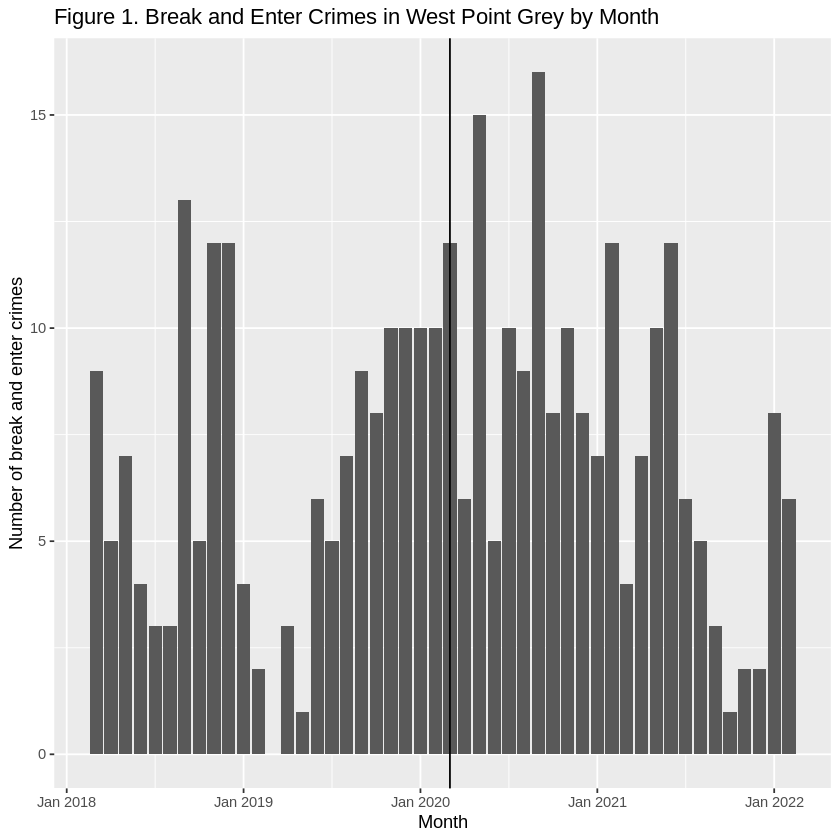

In [6]:
line_plot <- wpg |>
    filter(TYPE == "Break and Enter Commercial" | TYPE == "Break and Enter Residential/Other") |>
    mutate(YEARMON = as.yearmon(paste(YEAR, MONTH), "%Y %m")) |> # Convert YEAR and MONTH columns to date
    ggplot() +
    geom_bar(aes(x = YEARMON)) +
    geom_vline(xintercept = as.yearmon(paste(2020, 03), "%Y %m")) + # Vertical line at March 2020
    labs(title = "Figure 1. Break and Enter Crimes in West Point Grey by Month",
         x = "Month", 
         y = "Number of break and enter crimes")

line_plot

Next, we calculate summary statistics for the proportion of break and enter crimes (out of all crimes) across both time periods. The number of break-and-enter crimes is greater post-COVID (184 vs. 158) but the total number of crimes is less (780 vs. 882). As such, the proportion is greater post-COVID (0.236 vs. 0.179).

In [8]:
summary_tibble <- wpg |>
    group_by(PERIOD) |>
    summarize(n_break = sum(TYPE == "Break and Enter Commercial" | TYPE == "Break and Enter Residential/Other"),
              n_total = n()) |>
    mutate(prop_break = n_break / n_total)

summary_tibble

PERIOD,n_break,n_total,prop_break
<fct>,<int>,<int>,<dbl>
post,184,780,0.2358974
pre,158,882,0.1791383


A visual representation of the data is below, in the form of a stacked barplot.

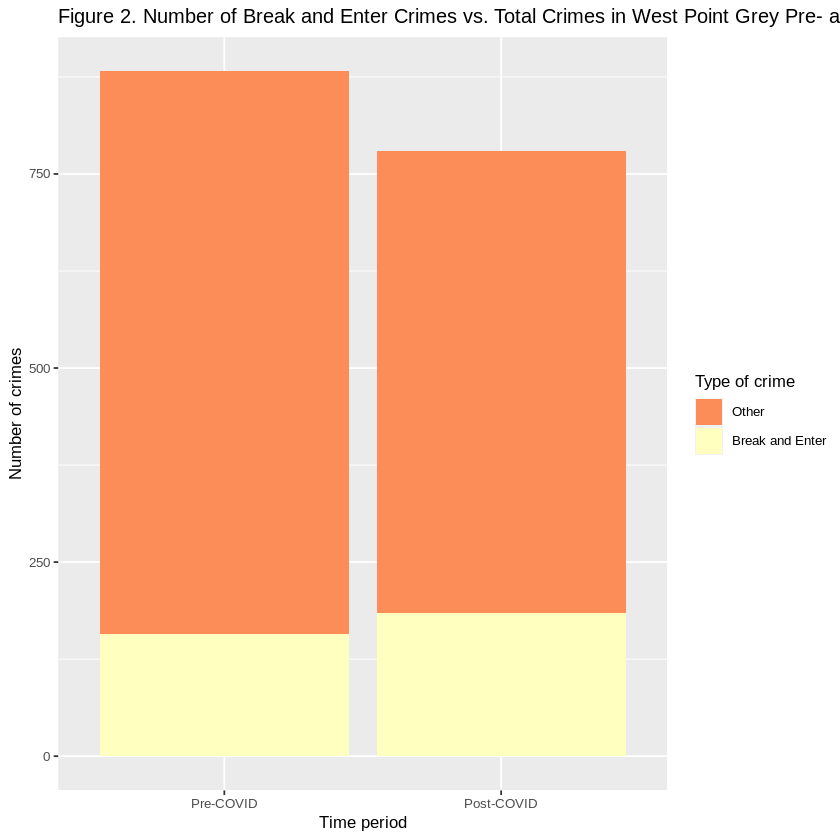

In [9]:
stacked_barplot <- wpg |>
    mutate(TYPE = case_when(((TYPE != "Break and Enter Commercial") & (TYPE != "Break and Enter Residential/Other")) ~ "Other",
                           ((TYPE == "Break and Enter Commercial") | (TYPE == "Break and Enter Residential/Other")) ~ "Break and Enter")) |>
    ggplot() +
    geom_bar(aes(x = factor(PERIOD, levels = c("pre", "post")), fill = factor(TYPE, levels = c("Other", "Break and Enter")))) +
    scale_x_discrete(labels = c("pre" = "Pre-COVID", "post" = "Post-COVID")) +
    labs(title = "Figure 2. Number of Break and Enter Crimes vs. Total Crimes in West Point Grey Pre- and Post-COVID", 
         x = "Time period", 
         y = "Number of crimes", 
         fill = "Type of crime") +
    theme(text = element_text(size = 10)) +
    scale_fill_brewer(palette = "Spectral")

stacked_barplot

We can observe from the summary table and the barplot that the total number of crimes decreased post-COVID, but the number of break and enter crimes increased. Is this difference significant?

## 3. Methods: Plan

For our analysis, we will apply both the bootstrap method and asymptotic theory. Bootstrapping allows us to study the sampling distribution of break and enter crimes (denoted by B&E) that would otherwise be unknown without making assumptions regarding the distribution. This is very important because we do not have access to the population of crime in Vancouver. However, we can also make assumptions that would allow us to apply asymptotic theory, specifically Central Limit Theorem (CLT) since we know our sample was taken independently, has appropriate size and can produce a random estimator. As we see in the summary table our sample size is large enough (~800) but well under 10% of all crimes. CLT makes our proportion point estimate faithfully represent population proportion while accounting for the standard error of our point estimate through width of sampling distribution. It also allows us to approximate the sampling distribution of proportion of B&E by a normal distribution even if the population distribution is not normal. Useful estimations of a normal distribution can therefore be applied to our sampling distribution.

In the Preliminary Results section, we performed count and calculation of B&E proportion and the results are visualized to reflect possible differences pre- and post-COVID. However, we do not know if the difference in proportions is statistically significant. In order to address this gap, we will calculate the difference in proportion using the following steps: (1) explicitly state our null hypothesis (H0: p = p0, H1:p < p0), (2) obtain the null distribution using infer package, (3) obtain observed test statistics, (4) obtain p-value, (5) conclude whether null hypothesis is rejected or not, (6) obtain standard error based CI at 90% level (7) find mean and sd of difference in proportions, (8) obtain confidence intervals.

To summarize, we expect to find whether or not our null hypothesis of “there is no difference in the proportion of B&E crimes pre- and post-COVID” is rejected. This finding could inform future research and perhaps derive causal questions such as: Why did B&E become more frequent during COVID years when compared to other crimes? How can we reduce B&E through reducing “lockdown-like” conditions? How did crimes that are similar in nature with  B&E change during COVID time and what does that reflect about the impact of COVID on particular groups? The impact of our finding studies could be concrete work for criminal studies and social studies that can reduce B&E type of crime, crimes overall and analyze COVID-related societal impact.


## 4. References

VPD OPEN DATA. https://geodash.vpd.ca/opendata/. Last accessed Mar 18, 2023.

Buil-Gil, David, et al. “Offline Crime Bounces Back to Pre-Covid Levels, Cyber Stays High: Interrupted Time-Series Analysis in Northern Ireland.” Crime Science, vol. 10, no. 1, 2021, https://doi.org/10.1186/s40163-021-00162-9.

Shen, Yichen, et al. “COVID-19's Lockdown and Crime Victimization: The State of Emergency under the Abe Administration.” Asian Economic Policy Review, vol. 16, no. 2, 2021, pp. 327–348., https://doi.org/10.1111/aepr.12339. 